In [1]:
import pandas as pd

In [2]:
import numpy as np 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
email_content=['The booking is not confirmed','The booking is confirmed for first booking and not confirmed for second booking','The booking is rejected'  ]
count=CountVectorizer()
bag=count.fit_transform(email_content)
count.vocabulary_

{'the': 9,
 'booking': 1,
 'is': 5,
 'not': 6,
 'confirmed': 2,
 'for': 4,
 'first': 3,
 'and': 0,
 'second': 8,
 'rejected': 7}

In [4]:
bag.toarray()

array([[0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [1, 3, 2, 1, 2, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 1]], dtype=int64)

In [5]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
np.set_printoptions(precision=2)
tfidf.fit_transform(bag).toarray()

array([[0.  , 0.4 , 0.51, 0.  , 0.  , 0.4 , 0.51, 0.  , 0.  , 0.4 ],
       [0.27, 0.48, 0.41, 0.27, 0.54, 0.16, 0.21, 0.  , 0.27, 0.16],
       [0.  , 0.41, 0.  , 0.  , 0.  , 0.41, 0.  , 0.7 , 0.  , 0.41]])

In [6]:
import pandas as pd 
train=pd.read_csv(r'C:\Users\Varun Kurup\Documents\testdatamodrnn.csv',encoding='latin_1')
test=pd.read_csv(r'C:\Users\Varun Kurup\Documents\testdataset.csv',encoding='latin_1')
train.head(10)

,Text,Label
0,The booking is confirmed,2
1,booking is not confirmed,0
2,booking is rejected,0
3,booking is accepted,2
4,accepted,2
5,no booking record found,0
6,no booking found,0
7,we are pleased to confirm this booking,2
8,we are sorry this booking is not found,0
9,sorry the booking is not found,0


In [7]:
from collections import Counter
vocab=Counter()
for email_content in train.iloc[:,0]:
    for word in email_content.split(' '):
        vocab[word]+=1
vocab.most_common(20)

[('booking', 1247),
 ('is', 634),
 ('not', 498),
 ('', 493),
 ('found', 341),
 ('the', 330),
 ('confirmed', 288),
 ('no', 181),
 ('this', 166),
 ('we', 152),
 ('are', 148),
 ('record', 143),
 ('to', 138),
 ('in', 113),
 ('approved', 98),
 ('find', 97),
 ('accepted', 96),
 ('exists', 87),
 ('sorry', 86),
 ('rejected', 67)]

In [8]:
from bokeh.models import ColumnDataSource,LabelSet
from bokeh.plotting import figure,show,output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [9]:
import math

def plot_distribution(vocabulary):

    hist, edges = np.histogram(list(map(lambda x:math.log(x[1]),vocabulary.most_common())), density=True, bins=500)

    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="Word distribution accross all emails")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555", )
    show(p)

plot_distribution(vocab)


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Varun
[nltk_data]     Kurup\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
vocab_reduced=Counter()
for w,c in vocab.items():
    if not w in stop:
        vocab_reduced[w]=c
        
vocab_reduced.most_common(20)

[('booking', 1247),
 ('', 493),
 ('found', 341),
 ('confirmed', 288),
 ('record', 143),
 ('approved', 98),
 ('find', 97),
 ('accepted', 96),
 ('exists', 87),
 ('sorry', 86),
 ('rejected', 67),
 ('ok', 66),
 ('able', 65),
 ('confirm', 64),
 ('reservation', 58),
 ('present', 50),
 ('pleased', 49),
 ('confirmada', 48),
 ('cannot', 40),
 ('The', 32)]

In [12]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!! email man :) is <b>nice</b>'))
    

this email man is nice :)


In [13]:
from nltk.stem import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]



In [14]:
from sklearn.model_selection import train_test_split

# split the dataset in train and test
X = train.iloc[:,0]
y = train.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

In [16]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   30.3s finished
C:\Users\Varun Kurup\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Varun Kurup\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...e, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's...se_idf': [False], 'vect__norm': [None], 'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=T

In [17]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x0000027838BBA6A8>, 'vect__use_idf': False}
Best accuracy: 0.965


In [18]:
clf = gs_lr_tfidf.best_estimator_
print('Accuracy in test: %.3f' % clf.score(X_test, y_test))
from sklearn.metrics import classification_report
preds=clf.predict(X_test)
print(classification_report(preds,y_test))

Accuracy in test: 0.952
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       235
           1       0.79      0.96      0.87        27
           2       0.96      0.94      0.95       221

   micro avg       0.95      0.95      0.95       483
   macro avg       0.91      0.96      0.93       483
weighted avg       0.95      0.95      0.95       483



NameError: name 'pathlib' is not defined

In [29]:
email_content=["not confirmed","sorry we cannot find booking","booking is not found" ,"cancelled booking readded","booking kept on hold","booking is in consideration"]

preds=clf.predict(email_content)

for i in range(len(email_content)):
    print(f'{email_content[i]},{preds[i]}')

not confirmed,0
sorry we cannot find booking,0
booking is not found,0
cancelled booking readded,2
booking kept on hold,1
booking is in consideration,2


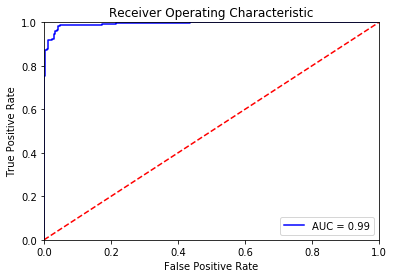

In [203]:
import sklearn.metrics as metrics
probs=clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()